In [ ]:
"""
1. Classic Lotka-Volterra:
   dx/dt = αx - βxy
   dy/dt = δxy - γy

2. With Carrying Capacity:
   dx/dt = αx(1 - x/K) - βxy
   dy/dt = δxy - γy

3. Stochastic (Euler-Maruyama):
   dx = [αx - βxy]dt + σ₁x dW₁
   dy = [δxy - γy]dt + σ₂y dW₂

4. Combined:
   dx = [αx(1 - x/K) - βxy]dt + σ₁x dW₁
   dy = [δxy - γy]dt + σ₂y dW₂

Parameters:
-----------
α : prey intrinsic growth rate
β : predation rate coefficient  
γ : predator mortality rate
δ : conversion efficiency of prey into predator growth
K : prey carrying capacity
σ₁, σ₂ : noise intensities for prey and predator
"""

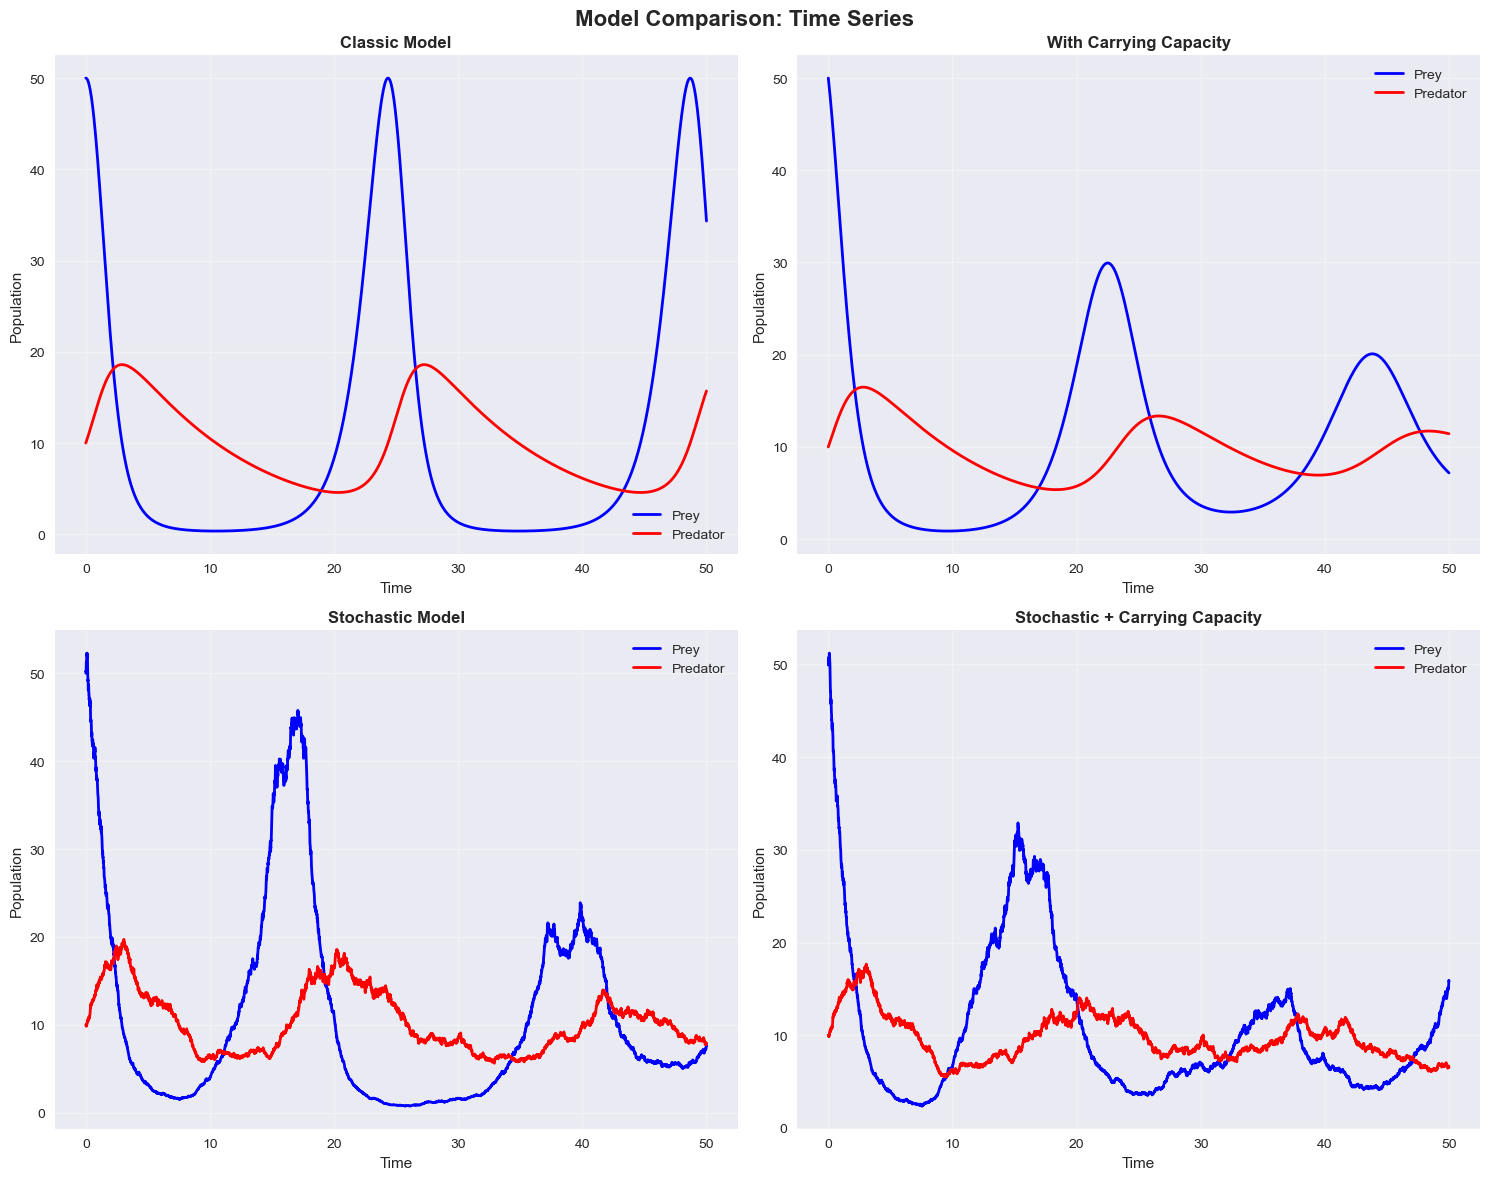

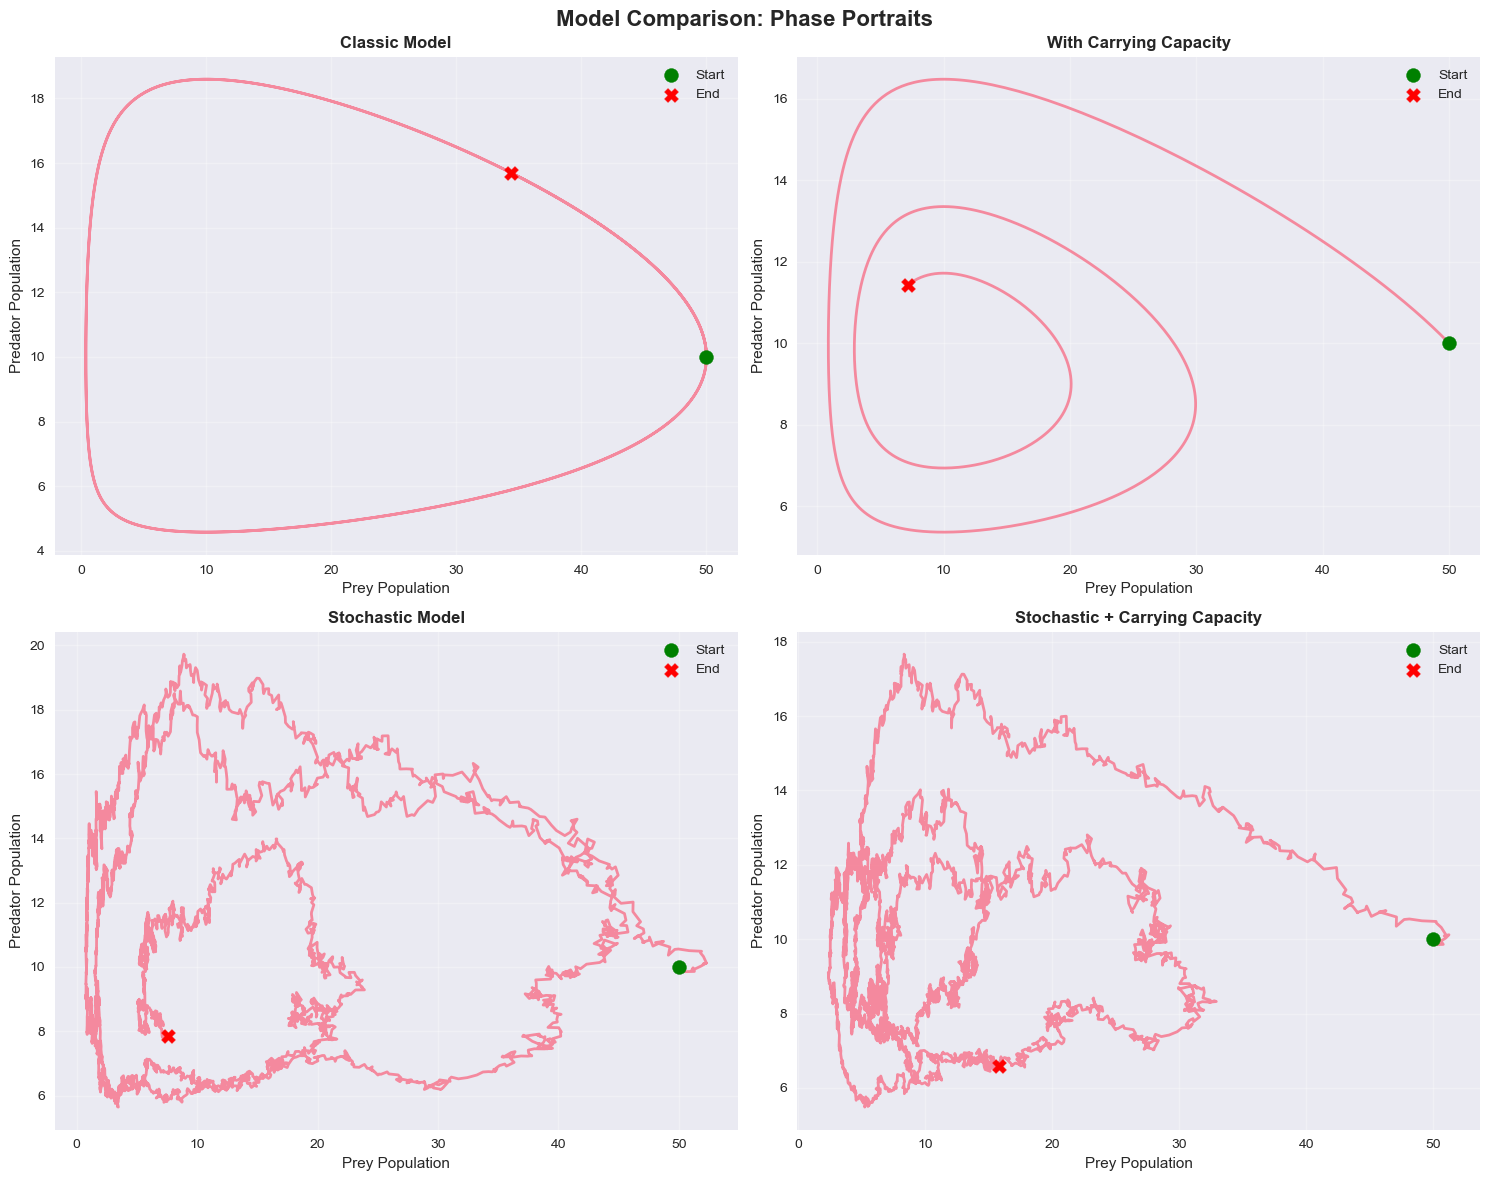

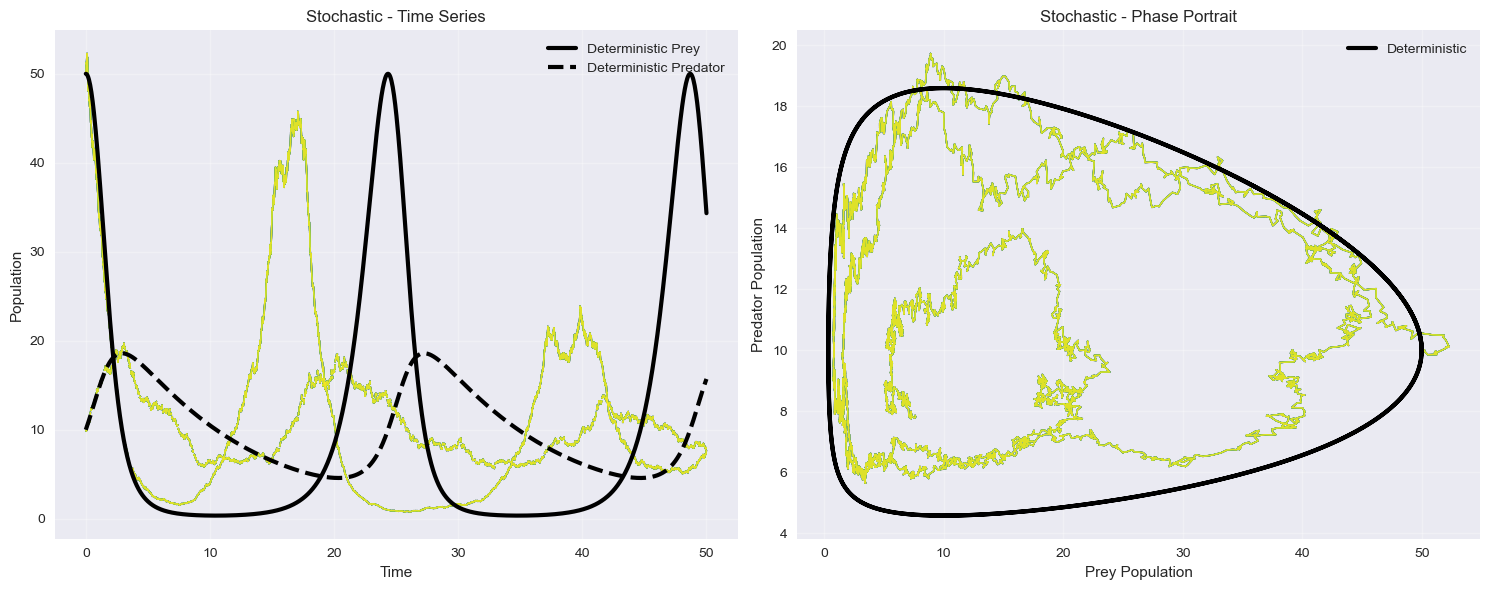

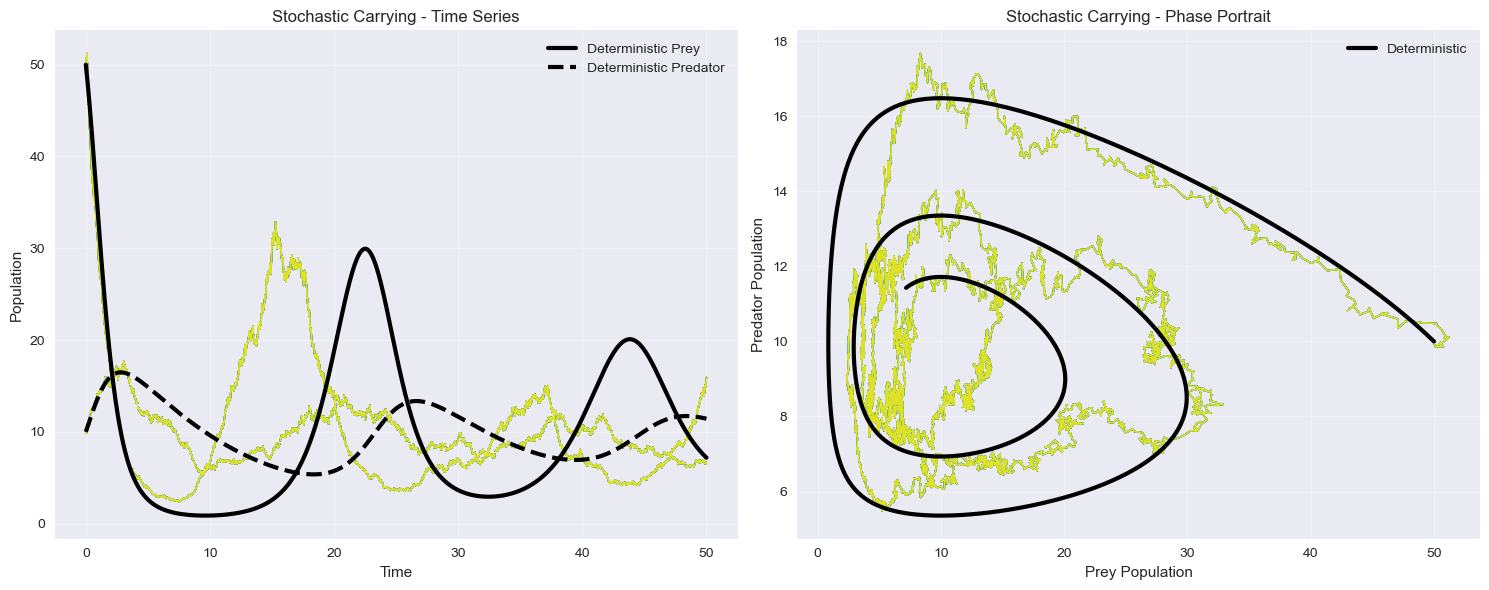

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from dataclasses import dataclass
from typing import Tuple, Optional
import seaborn as sns


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

@dataclass
class ModelParameters:
    alpha: float = 1.0      #prey growth rate
    beta: float = 0.1       #predation rate
    gamma: float = 0.1      #predator mortality
    delta: float = 0.01     #conversion efficiency
    K: float = 1000         #carrying capacity
    sigma1: float = 0.05    #prey noise intensity
    sigma2: float = 0.05    #predator noise intensity

class LotkaVolterraModels:
    
    def __init__(self, params: ModelParameters):
        self.params = params
    
    def classic_model(self, state, t):
        x, y = state
        dxdt = self.params.alpha * x - self.params.beta * x * y
        dydt = self.params.delta * x * y - self.params.gamma * y
        return [dxdt, dydt]
    
    def carrying_capacity_model(self, state, t):
        x, y = state
        dxdt = self.params.alpha * x * (1 - x/self.params.K) - self.params.beta * x * y
        dydt = self.params.delta * x * y - self.params.gamma * y
        return [dxdt, dydt]
    
    def simulate_deterministic(self, model_type: str, x0: float, y0: float, 
                             t_end: float = 50, num_points: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
        t = np.linspace(0, t_end, num_points)
        initial_conditions = [x0, y0]
        
        if model_type == "classic":
            sol = odeint(self.classic_model, initial_conditions, t)
        elif model_type == "carrying_capacity":
            sol = odeint(self.carrying_capacity_model, initial_conditions, t)
        else:
            raise ValueError("Check the model type")
        
        return t, sol
    
    def simulate_stochastic(self, model_type: str, x0: float, y0: float,
                          t_end: float = 50, dt: float = 0.01) -> Tuple[np.ndarray, np.ndarray]:

        num_steps = int(t_end / dt)
        t = np.linspace(0, t_end, num_steps + 1)
        
        # Initialize arrays
        x = np.zeros(num_steps + 1)
        y = np.zeros(num_steps + 1)
        x[0], y[0] = x0, y0
        
        np.random.seed(42) 
        dW1 = np.random.normal(0, np.sqrt(dt), num_steps)
        dW2 = np.random.normal(0, np.sqrt(dt), num_steps)
        
        for i in range(num_steps):
            if model_type == "stochastic":
                drift_x = self.params.alpha * x[i] - self.params.beta * x[i] * y[i]
                drift_y = self.params.delta * x[i] * y[i] - self.params.gamma * y[i]
            elif model_type == "stochastic_carrying":
                drift_x = (self.params.alpha * x[i] * (1 - x[i]/self.params.K) - 
                          self.params.beta * x[i] * y[i])
                drift_y = self.params.delta * x[i] * y[i] - self.params.gamma * y[i]
            else:
                raise ValueError("check ")
            
            x[i+1] = max(0, x[i] + drift_x * dt + self.params.sigma1 * x[i] * dW1[i])
            y[i+1] = max(0, y[i] + drift_y * dt + self.params.sigma2 * y[i] * dW2[i])
        
        return t, np.column_stack([x, y])

class ModelVisualizer:
    
    @staticmethod
    def plot_time_series(results_dict: dict, title: str = "Population Dynamics"):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        colors = ['blue', 'red']
        labels = ['Prey', 'Predator']
        
        for idx, (model_name, (t, sol)) in enumerate(results_dict.items()):
            row, col = idx // 2, idx % 2
            ax = axes[row, col]
            
            for i in range(2):
                ax.plot(t, sol[:, i], color=colors[i], label=labels[i], linewidth=2)
            
            ax.set_title(model_name.replace('_', ' ').title(), fontweight='bold')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_phase_portraits(results_dict: dict, title: str = "Phase Portraits"):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        for idx, (model_name, (t, sol)) in enumerate(results_dict.items()):
            row, col = idx // 2, idx % 2
            ax = axes[row, col]
            
            ax.plot(sol[:, 0], sol[:, 1], linewidth=2, alpha=0.8)
            ax.scatter(sol[0, 0], sol[0, 1], color='green', s=100, 
                      marker='o', label='Start', zorder=5)
            ax.scatter(sol[-1, 0], sol[-1, 1], color='red', s=100, 
                      marker='X', label='End', zorder=5)
            
            ax.set_title(model_name.replace('_', ' ').title(), fontweight='bold')
            ax.set_xlabel('Prey Population')
            ax.set_ylabel('Predator Population')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def compare_stochastic_realizations(model: LotkaVolterraModels, model_type: str,
                                      x0: float, y0: float, num_realizations: int = 10):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        colors = plt.cm.viridis(np.linspace(0, 1, num_realizations))
        
        for i in range(num_realizations):
            np.random.seed(i)
            t, sol = model.simulate_stochastic(model_type, x0, y0)
            
            ax1.plot(t, sol[:, 0], color=colors[i], alpha=0.6, linewidth=1)
            ax1.plot(t, sol[:, 1], color=colors[i], alpha=0.6, linewidth=1, linestyle='--')
            
            ax2.plot(sol[:, 0], sol[:, 1], color=colors[i], alpha=0.6, linewidth=1)
        

        if model_type == "stochastic":
            t_det, sol_det = model.simulate_deterministic("classic", x0, y0)
        else:
            t_det, sol_det = model.simulate_deterministic("carrying_capacity", x0, y0)
        
        ax1.plot(t_det, sol_det[:, 0], 'k-', linewidth=3, label='Deterministic Prey')
        ax1.plot(t_det, sol_det[:, 1], 'k--', linewidth=3, label='Deterministic Predator')
        
        ax2.plot(sol_det[:, 0], sol_det[:, 1], 'k-', linewidth=3, label='Deterministic')
        
        ax1.set_title(f'{model_type.replace("_", " ").title()} - Time Series')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Population')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.set_title(f'{model_type.replace("_", " ").title()} - Phase Portrait')
        ax2.set_xlabel('Prey Population')
        ax2.set_ylabel('Predator Population')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def main():
    params = ModelParameters(
        alpha=1.0,
        beta=0.1,
        gamma=0.1,
        delta=0.01,
        K=200,
        sigma1=0.1,
        sigma2=0.1
    )
    
    model = LotkaVolterraModels(params)
    visualizer = ModelVisualizer()
    
    x0, y0 = 50, 10
    
    results = {}
    
    t_classic, sol_classic = model.simulate_deterministic("classic", x0, y0)
    results["Classic Model"] = (t_classic, sol_classic)
    
    t_carrying, sol_carrying = model.simulate_deterministic("carrying_capacity", x0, y0)
    results["With Carrying Capacity"] = (t_carrying, sol_carrying)
    
    np.random.seed(42)
    t_stoch, sol_stoch = model.simulate_stochastic("stochastic", x0, y0)
    results["Stochastic Model"] = (t_stoch, sol_stoch)
    
    np.random.seed(42)
    t_stoch_carry, sol_stoch_carry = model.simulate_stochastic("stochastic_carrying", x0, y0)
    results["Stochastic + Carrying Capacity"] = (t_stoch_carry, sol_stoch_carry)
    
    visualizer.plot_time_series(results, "Model Comparison: Time Series")
    visualizer.plot_phase_portraits(results, "Model Comparison: Phase Portraits")
    
    visualizer.compare_stochastic_realizations(
        model, "stochastic", x0, y0, num_realizations=15
    )
    
    visualizer.compare_stochastic_realizations(
        model, "stochastic_carrying", x0, y0, num_realizations=15
    )
    
    return results, model

if __name__ == "__main__":
    results, model = main()